In [1]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from gnn.models import GINModel

from gnn.dataloader import *
from gnn.dgldataset import HandGestureDataset
from gnn.dataloader import HandGestureDataLoader
import matplotlib.pyplot as plt
import dgl
%matplotlib inline

In [17]:
def draw_plot(train_losses, val_losses, val_accs, train_accs):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Training Progress')

    axes[0].plot(train_losses, label='Training')
    axes[0].plot(val_losses, label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(val_accs, label='Validation')
    axes[1].plot(train_accs, label='Train')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()



def train(model, train_loader, val_loader, lr=0.01, epochs=20):
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs = []
    # Define optimizer and loss function
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = CrossEntropyLoss()

    # Train the model
    epochs = epochs

    for epoch in range(epochs):
        # Set model to the train mode
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        # Train on batches
        for batch_idx, (bg, labels) in enumerate(train_loader):
            # Forward pass
            features = bg.ndata['feat']
            logits = model(bg, features)

            # print(logits.size(), labels.size())

            # Compute loss
            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            predicted = torch.argmax(logits, dim=1)
            true_labels = torch.argmax(labels, dim=1)
            total_train_correct += (predicted == true_labels).sum().item()
            total_train_samples += true_labels.shape[0]

        train_acc = total_train_correct / total_train_samples

        # Evaluate on validation set
        model.eval()
        total_val_loss = 0.0
        total_val_acc = 0.0
        with torch.no_grad():
            for batch_idx, (bg, labels) in enumerate(val_loader):
                # Forward pass
                features = bg.ndata['feat']
                logits = model(bg, features)

                # Compute loss
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                # Compute accuracy
                predicted = torch.argmax(logits, dim=1)
                true_labels = torch.argmax(labels, dim=1)
                # print(f'The predicted is: {predicted}, the true_label is: {true_labels}')
                # print(f'The correct number was: {(predicted == true_labels).sum()}, the number of all candidates is: {len(true_labels)}, the number of val_loader is: {len(val_loader)}')
                total_val_acc += ((predicted == true_labels).sum()).item()

            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_acc = total_val_acc / len(hand_gesture_dataloader.val_indices)

            # Print training and validation loss for the epoch
            print('Epoch {}, Train Accuracy {:.4f}, Train Loss {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}'.format(epoch, train_acc,
                                                                                             total_train_loss / len(
                                                                                                 train_loader),
                                                                                             avg_val_loss, avg_val_acc))

            val_losses.append(avg_val_loss)
            train_losses.append(total_train_loss / len(train_loader))
            val_accs.append(avg_val_acc)
            train_accs.append(train_acc)

    draw_plot(train_losses=train_losses, val_losses=val_losses, val_accs=val_accs, train_accs=train_accs)
    return model

In [3]:
def test(model, test_loader):
    criterion = CrossEntropyLoss()
    # Evaluate on test set
    model.eval()
    total_test_loss = 0.0
    total_test_acc = 0.0
    with torch.no_grad():
        for batch_idx, (bg, labels) in enumerate(test_loader):
            # Forward pass
            features = bg.ndata['feat']
            logits = model(bg, features)

            # Compute loss
            loss = criterion(logits, labels)
            total_test_loss += loss.item()

            # Compute accuracy
            predicted = torch.argmax(logits, dim=1)
            true_labels = torch.argmax(labels, dim=1)
            total_test_acc += ((predicted == true_labels).sum()).item()

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_acc / len(hand_gesture_dataloader.test_indices)

        print('Test Loss {:.4f}, Test Accuracy {:.4f}'.format(avg_test_loss, avg_test_acc))

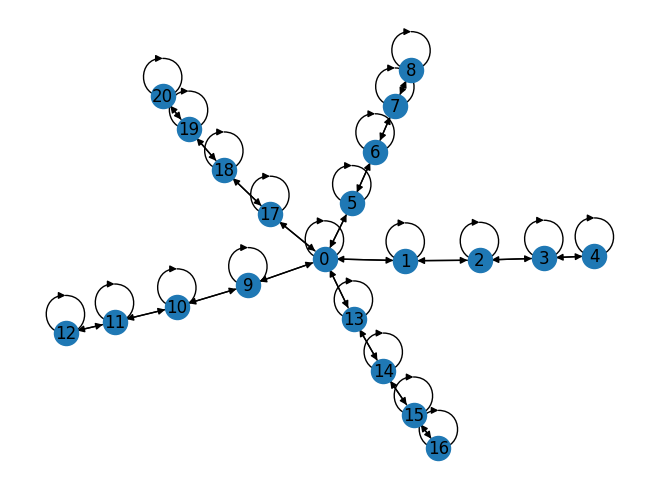

In [4]:
import networkx as nx

# Create the dgl dataset
hand_gesture_dataset = HandGestureDataset()

# Define data loader
hand_gesture_dataloader = HandGestureDataLoader(dataset=hand_gesture_dataset, test_split=0.3, val_split=0.1)
train_loader = hand_gesture_dataloader.get_train_loader()
test_loader = hand_gesture_dataloader.get_test_loader()
val_loader = hand_gesture_dataloader.get_val_loader()

num_node_feature_dim = hand_gesture_dataset.num_node_feature_dim      # Get the number of features for each node - 3
num_classes = hand_gesture_dataset.num_classes                  # Get the number of classes - 36
num_node_feature_dim, num_classes

g = hand_gesture_dataset[0][0]
nx_g = g.to_networkx()

# Plot using NetworkX
nx.draw(nx_g, with_labels=True)

Epoch 0, Train Accuracy 0.0904, Train Loss 13.4336, Val Loss 3.4996, Val Accuracy 0.3416
Epoch 1, Train Accuracy 0.2487, Train Loss 4.6689, Val Loss 2.1074, Val Accuracy 0.5528
Epoch 2, Train Accuracy 0.3484, Train Loss 3.3316, Val Loss 1.4251, Val Accuracy 0.6646
Epoch 3, Train Accuracy 0.4286, Train Loss 2.6148, Val Loss 1.1303, Val Accuracy 0.7143
Epoch 4, Train Accuracy 0.4615, Train Loss 2.4729, Val Loss 1.1701, Val Accuracy 0.7267
Epoch 5, Train Accuracy 0.4943, Train Loss 2.1388, Val Loss 1.0174, Val Accuracy 0.7205
Epoch 6, Train Accuracy 0.5159, Train Loss 1.9923, Val Loss 0.9698, Val Accuracy 0.8012
Epoch 7, Train Accuracy 0.5612, Train Loss 1.7626, Val Loss 0.7917, Val Accuracy 0.7826
Epoch 8, Train Accuracy 0.5961, Train Loss 1.6135, Val Loss 0.8138, Val Accuracy 0.7764
Epoch 9, Train Accuracy 0.5940, Train Loss 1.6042, Val Loss 0.9558, Val Accuracy 0.8075
Epoch 10, Train Accuracy 0.6166, Train Loss 1.5534, Val Loss 0.7445, Val Accuracy 0.8323
Epoch 11, Train Accuracy 0.601

<Figure size 640x480 with 0 Axes>

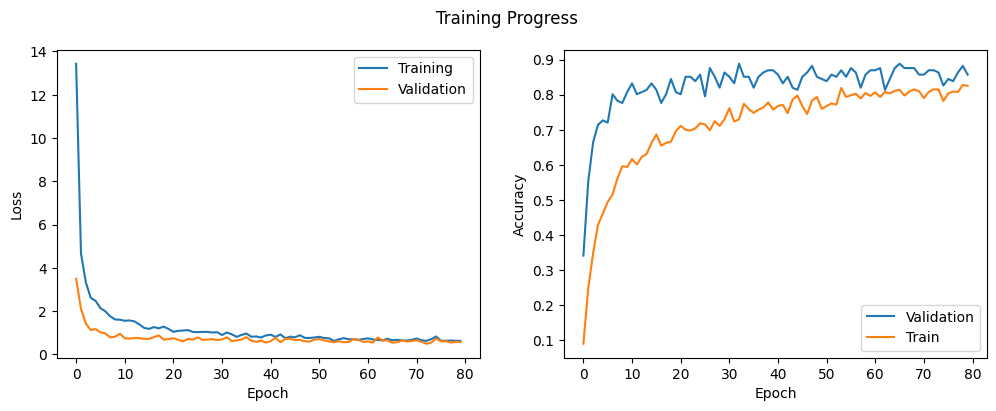

Test Loss 0.2889, Test Accuracy 0.9134


In [19]:
gin = GINModel(in_feats=num_node_feature_dim, n_hidden=32, out_dim=num_classes)
# Train the model
gin_trained_model = train(gin, train_loader, val_loader, lr=0.001, epochs=80)
# Test the model
test(gin_trained_model, test_loader)

In [6]:
# Save the model
torch.save(gin_trained_model.state_dict(), 'gin_model.pt')

GAT_Net(
  (elu): ELU(alpha=1.0)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=36, out_features=36, bias=True)
  (MultiHeadGATlayers): ModuleList(
    (0): MultiHeadGATLayer(
      (heads): ModuleList(
        (0-2): 3 x GATLayer(
          (W): Linear(in_features=3, out_features=10, bias=True)
          (A): Linear(in_features=20, out_features=1, bias=True)
          (dropout): Dropout(p=0.6, inplace=False)
          (relu): LeakyReLU(negative_slope=0.2)
          (softmax): Softmax(dim=1)
        )
      )
    )
    (1): MultiHeadGATLayer(
      (heads): ModuleList(
        (0-2): 3 x GATLayer(
          (W): Linear(in_features=30, out_features=36, bias=True)
          (A): Linear(in_features=72, out_features=1, bias=True)
          (dropout): Dropout(p=0.6, inplace=False)
          (relu): LeakyReLU(negative_slope=0.2)
          (softmax): Softmax(dim=1)
        )
      )
    )
  )
)
Epoch 0, Train Accuracy 0.0308, Train Loss 3.570

<Figure size 640x480 with 0 Axes>

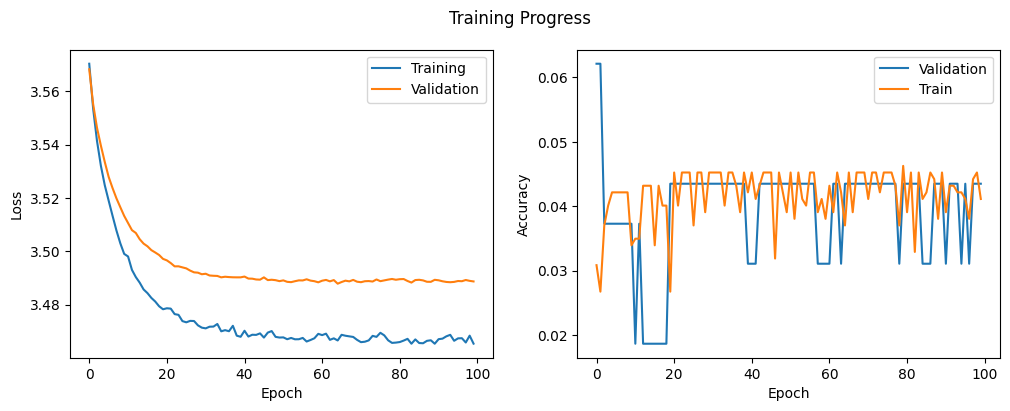

Test Loss 3.4632, Test Accuracy 0.0351


In [20]:
from gnn.models import GAT_Net

gat = GAT_Net(in_feats=num_node_feature_dim, n_hidden=10, n_classes=num_classes, n_layers=2, n_heads=3, dropout=0.2)
print(gat)
# Train the model
gat_trained_model = train(gat, train_loader, val_loader, lr=0.001, epochs=100)
# Test the model
test(gat_trained_model, test_loader)

Classifier(
  (conv1): GraphConv(in=3, out=10, normalization=both, activation=None)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=36, bias=True)
)
Epoch 0, Train Accuracy 0.0421, Train Loss 3.5272, Val Loss 3.4949, Val Accuracy 0.0435
Epoch 1, Train Accuracy 0.0339, Train Loss 3.4807, Val Loss 3.4847, Val Accuracy 0.0248
Epoch 2, Train Accuracy 0.0349, Train Loss 3.4742, Val Loss 3.4871, Val Accuracy 0.0186
Epoch 3, Train Accuracy 0.0329, Train Loss 3.4736, Val Loss 3.4835, Val Accuracy 0.0373
Epoch 4, Train Accuracy 0.0391, Train Loss 3.4730, Val Loss 3.4830, Val Accuracy 0.0311
Epoch 5, Train Accuracy 0.0339, Train Loss 3.4707, Val Loss 3.4752, Val Accuracy 0.0435
Epoch 6, Train Accuracy 0.0277, Train Loss 3.4735, Val Loss 3.4903, Val Accuracy 0.0373
Epoch 7, Train Accuracy 0.0349, Train Loss 3.4702, Val Loss 3.4913, Val Accuracy 0.0435
Epoch 8, Train Accuracy 0.0411, Train Loss 3.4732, Val Loss 3.4822, Val Accuracy 0.0311
Ep

<Figure size 640x480 with 0 Axes>

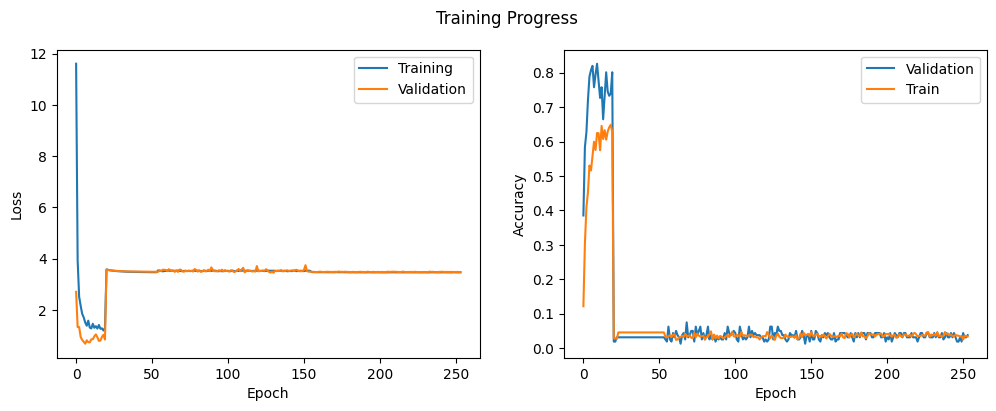

Test Loss 3.4520, Test Accuracy 0.0392


In [9]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        # self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h))
        # h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'h')
            h = self.fc1(hg)
            h = self.fc2(h)
            return h


model = Classifier(num_node_feature_dim, 10, num_classes)
print(model)
# Train the model
gat_trained_model = train(model, train_loader, val_loader, lr=0.01, epochs=100)
# Test the model
test(gat_trained_model, test_loader)